In [1]:
# This file uses the inhouse qcbm code from the paper and compares MMD with MCR
import numpy as np
import matplotlib.pyplot as plt
import copy
import q_circuit as q # In house circuit code, to comare with Qiskit
import torch
import time
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
# Oh Hail the almighty Qiskit:
import qiskit
from qiskit import transpile, assemble
from qiskit.visualization import *
from qiskit import IBMQ
from qiskit.providers.jobstatus import JobStatus

# Import custom packages: These are written by me
import InHouse_Circuits as ihc
import Qiskit_Circuits as qkc
import Q_Generator as QG
import Q_Loss_and_Gradients as Q_gradients
import Utils
import Discriminator_Utils as D_utils # A file that contains different discriminator architectures
import time



In [2]:
# IBMQ.enable_account("a66a83268fbf696a24b481c5d7568d50f14a1b2f28c6932d600a625b9cbffc6e28a6594bdd422676c9b2a214dcafa87d57012cc8678cbabaeecb319a0515f4c2")

In [3]:
# provider = IBMQ.get_provider(hub='ibm-q')
# provider.backends()

In [4]:
#backend = provider.get_backend('simulator_statevector')

Debug against quspin exact diagonalization

In [5]:
#======================================Start of Configurations=================================
n_qubits = 6 # We use 6 qubits, two hidden
n_h_qubits = 2
n_show_qubits = n_qubits-n_h_qubits
x_basis_m_n = torch.FloatTensor(Utils.binary_basis((n_show_qubits,))) 
sigma_list = [0.1,0.25,4,10]
K = Utils.mix_rbf_kernel(x_basis_m_n, x_basis_m_n, sigma_list)
connections = [(0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5,0)]
print('connection scheme', connections)
 
simulator = qiskit.Aer.get_backend('statevector_simulator')

# t_m is the duration of each quench temperature, one delta_t time corresponds to one
# There is no quenche layers set up when you first call the circuit initialization:
circuit0 = qkc.MBL_Circuit_quench(delta_t=0.001, t_m=0.01, Jxy=1.0, Jzz=1.0, 
                                  n_qubits=n_qubits, n_h_qubits=n_h_qubits, 
                                  connections=connections, backend=simulator)
circuit0._circuit.draw()

connection scheme [(0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 0)]


»
q_0: »
     »
q_1: »
     »
q_2: »
     »
q_3: »
     »
q_4: »
     »
q_5: »
     »
c: 4/»
     »
«     ┌──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐»
«q_0: ┤0                                                                                                                                             ├»
«     │                                                                                                                                              │»
«q_1: ┤1                                                                                                                                             ├»
«     │                                                                                                                                              │»
«q_2: ┤2                                                                                                                                             ├»
«     │  Initialize(1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0) │»
«q_3: ┤3                                                                                                                                             ├»
«     │                                                                                                                                              │»
«q_4: ┤4                                                                                                                                             ├»
«     │                                                                                                                                              │»
«q_5: ┤5                                                                                                                                             ├»
«     └──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘»
«c: 4/════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════»
«                                                                                                                                                     »
«     ┌───────────────┐┌────┐┌────┐┌────┐┌───────────────┐┌───────────────┐»
«q_0: ┤ Rz(0.001*h_0) ├┤0   ├┤0   ├┤0   ├┤ Rz(0.001*h_0) ├┤ Rz(0.001*h_0) ├»
«     ├───────────────┤│    ││    ││    │├───────────────┤├───────────────┤»
«q_1: ┤ Rz(0.001*h_1) ├┤1   ├┤1   ├┤1   ├┤ Rz(0.001*h_1) ├┤ Rz(0.001*h_1) ├»
«     ├───────────────┤│    ││    ││    │├───────────────┤├───────────────┤»
«q_2: ┤ Rz(0.001*h_2) ├┤2   ├┤2   ├┤2   ├┤ Rz(0.001*h_2) ├┤ Rz(0.001*h_2) ├»
«     ├───────────────┤│  B ││  C ││  B │├───────────────┤├───────────────┤»
«q_3: ┤ Rz(0.001*h_3) ├┤3   ├┤3   ├┤3   ├┤ Rz(0.001*h_3) ├┤ Rz(0.001*h_3) ├»
«     ├───────────────┤│    ││    ││    │├───────────────┤├───────────────┤»
«q_4: ┤ Rz(0.001*h_4) ├┤4   ├┤4   ├┤4   ├┤ Rz(0.001*h_4) ├┤ Rz(0.001*h_4) ├»
«     ├───────────────┤│    ││    ││    │├───────────────┤├───────────────┤»
«q_5: ┤ Rz(0.001*h_5) ├┤5   ├┤5   ├┤5   ├┤ Rz(0.001*h_5) ├┤ Rz(0.001*h_5) ├»
«     └───────────────┘└────┘└────┘└────┘└───────────────┘└───────────────┘»
«c: 4/═════════════════════════════════════════════════════════════════════»
«                                                                          »
«     ┌────┐┌────┐┌────┐┌───────────────┐┌───────────────┐┌────┐┌────┐┌────┐»
«q_0: ┤0   ├┤0   ├┤0   ├┤ Rz(0.001*h_0) ├┤ Rz(0.001*h_0) ├┤0   ├┤0   ├┤0   ├»
«     │    ││    ││    │├───────────────┤├───────────────┤│    ││    ││    │»
«q_1: ┤1   ├┤1   ├┤1   ├┤ Rz(0.001*h_1) ├┤ Rz(0.001*h_1) ├┤1   ├┤1   ├┤1   ├»
«     │    ││    ││    │├───────────────┤├───────────────┤│    ││    ││    │»
«q_2: ┤2   ├┤2   ├┤2   ├┤ Rz(0.001*h_2) ├┤ Rz(0.001*h_2) ├┤2   ├┤2   ├┤2   

Text(0.5, 1.0, 'target distribution')

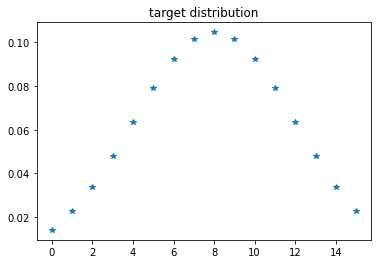

In [6]:
#======================================Create p_data==========================================
hdim = 2**n_show_qubits
p_data = torch.FloatTensor(Utils.gaussian_pdf((n_show_qubits,), hdim/2., hdim/4.))
plt.plot(p_data, '*')
plt.title('target distribution')


In [7]:
'1'*int(n_qubits/2)+'0'*int(n_qubits/2)

'111000'

Fast: training loop with saved statevector at each quench

In [8]:
M = 100 # Total number of quenches
n_branches = 500 # number of search branches at each quench
hd = 20 # Range of the randomly selected localization conef [-hd, +hd]
training_losses = [] # To record the best mmd out of all candidate points at each quench m

# Prepare the initial domain wall state via statevec
state = qiskit.quantum_info.Statevector.from_label('1'*int(n_qubits/2)+'0'*int(n_qubits/2))
print('wallstate', state)

wallstate Statevector([0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
             0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
             0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
             0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
             0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
             0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
             0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
             0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
             1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
             0.+0.j],
            dims=(2, 2, 2, 2, 2, 2))


In [9]:
circuit0._circuit.data[0]

(Instruction(name='initialize', num_qubits=6, num_clbits=0, params=[(1+0j), 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j]),
 [Qubit(QuantumRegister(6, 'q'), 0),
  Qubit(QuantumRegister(6, 'q'), 1),
  Qubit(QuantumRegister(6, 'q'), 2),
  Qubit(QuantumRegister(6, 'q'), 3),
  Qubit(QuantumRegister(6, 'q'), 4),
  Qubit(QuantumRegister(6, 'q'), 5)],
 [])

In [10]:
states = []
probs = []
for m in range(M):
    t0 = time.time()
    # load the state from previous quench
    circuit0.load_arbitrary_state(state)
    
    # First randomly select candidate configurations of hz for quench m:
    mmds = []
    theta_list_array = []
    for b in range(n_branches):
        # Only randomly earch prameterse for this specific quench
        theta_list_m = (torch.rand( circuit0.n_qubits )*2-1)*hd
        # use these parameters 
        px, _ = circuit0.pdf_actual(theta_list_m)
        mmd_distance = px@K@(p_data.T)
        mmds.append(mmd_distance)
        theta_list_array.append(theta_list_m) # keep a record of this for debugging
    
    ind = np.argmin(mmds)
    print('best mmd', mmds[ind])
    training_losses.append(mmds[ind])
    # Recalculate the best evolved state for the next quench
    px, state = circuit0.pdf_actual(theta_list_array[ind]) # returns a StateVector object
    states.append(state)
    probs.append(px)
    t1 = time.time()
    print('time', t1-t0)

/Users/pengyuanzhai/Documents/MBL_Born/Qiskit_Circuits.py:248: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /tmp/pip-req-build-7w1l4mea/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.FloatTensor(probabilities), full_statevec
/Users/pengyuanzhai/Documents/MBL_Born/Qiskit_Circuits.py:248: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at  /tmp/pip-req-build-7w1l4mea/aten/src/ATen/native/Copy.cpp:162.)
  return torch.FloatTensor(probabilities), full_statevec


best mmd tensor(1.9520)
time 23.222934007644653
best mmd tensor(1.9519)
time 23.329622983932495
best mmd tensor(1.9516)
time 22.25683903694153
best mmd tensor(1.9513)
time 22.80996823310852


KeyboardInterrupt: 

In [ ]:
plt.plot(probs[0])

In [ ]:
plt.plot(probs[1])

In [ ]:
plt.plot(probs[2])

In [ ]:
plt.plot(states[0].data)

In [ ]:
plt.plot(states[1].data)

In [ ]:
plt.plot(states[2].data)

In [ ]:
plt.plot(states[5].data)

In [ ]:
circuit0.thetas

In [ ]:
phi = qiskit.circuit.Parameter('phi')
phi2 = qiskit.circuit.Parameter('phi')
qc = qiskit.QuantumCircuit(1)
print('qc first praemeter', qc._parameter_table)
# parameterize the rotation
qc.rx(phi, 0)
print(qc.data)
qc.draw()

# bind the parameters after circuit to create a bound circuit
bc = qc.bind_parameters({phi: 3.14})
bc.measure_all()
bc.draw()
qc.rx(phi,0)
qc.rx(phi,0)



In [ ]:
A = []
theta = qiskit.circuit.Parameter('t')
A.append(theta)

In [ ]:
theta in A

In [ ]:
theta1 = qiskit.circuit.Parameter('t')
theta1 in A

In [ ]:
theta2 = copy.deepcopy(theta)
theta2 in A

In [ ]:
id(theta2)

In [ ]:
id(theta)

In [ ]:
id(theta1)

In [ ]:
theta2.name='new-t'

In [ ]:
qc._parameter_table

phi5 = copy.deepcopy(phi4)

In [ ]:
phi5 in qc._parameter_table

In [ ]:
phi3=phi# pass by reference
import copy
phi4=copy.deepcopy(phi)
qc.rx(phi4,0)# meaning that qiskist doesn't detect parameter duplicatres via address

In [ ]:
psi0=qiskit.circuit.Parameter('psi0')
qc._update_parameter_table(qc.data[0][0])

In [ ]:
qc.rx(phi2,0)

In [ ]:
qc.data

In [ ]:
phi4==phi

In [ ]:
phi.parameters

In [ ]:
qc.rx(phi2,0)

In [ ]:
qc._parameter_table.clear()

In [ ]:
qc.rx(phi2,0)

In [ ]:
circuit0._circuit.data

In [ ]:
circuit0._circuit.draw()

In [ ]:
torch.cat([torch.Tensor(), torch.zeros((3))])

In [ ]:
torch.ones(3)@torch.ones((3,3))@torch.ones(3)

In [ ]:
(torch.rand( (circuit0.current_m+1)*circuit0.n_qubits )*2-1)*1.8